<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Localizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
tf.enable_eager_execution()

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. Not all the images have bounding boxes predictions. The bounding box annotates the head of the pet. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)



# Download the images/annot and unzip the files 

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

In [0]:
def getBB(file):
  
  #parse the annotations
  path = f'annotations/xmls/{file}'
  tree = ET.parse(path)
  root = tree.getroot()
  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text

  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text

  return((int(xmin), int(ymin)), (int(xmax), int(ymax)))

def drawBB(file):
  #draw the bounding box
  img_path = f'images/{file[:-4]}.jpg'
  img = cv2.imread(img_path)
  
  (xmin, ymin), (xmax, ymax) = getBB(file)

  print(getBB(file))
  annotated = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  
  plt.imshow(annotated[:,:,::-1])
  plt.axis('off')
  plt.show()

((84, 86), (204, 196))


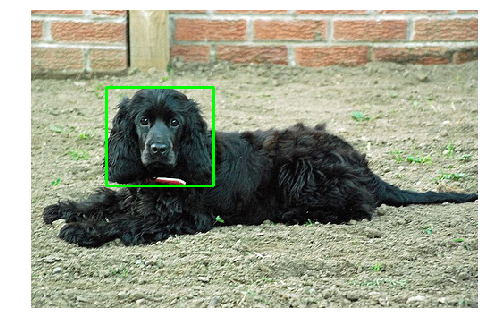

In [5]:
file = np.random.choice(os.listdir('annotations/xmls/'))
drawBB(file)

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        img_path = f'images/{f[:-4]}.jpg'
        img = Image.open(img_path)
        w,h = img.size
        
        img = img.resize(sz)
        (xmin, ymin), (xmax, ymax) = getBB(f)
        
        img = np.array(img).astype('float32')
        if len(img.shape) == 2:
          img = np.stack((img,)*3, axis=-1)

        else:
          img = img[:,:,0:3]
        
        box = np.array([xmin/w, ymin/h, xmax/w, ymax/h])

        batch_x.append(img/255)
        batch_y.append(box)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    yield (batch_x, batch_y)      
    

In [7]:
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir('annotations/xmls/')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
train_generator = image_generator(train_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))
test_generator  = image_generator(test_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))

Size of training  3501
Size of testing   185


In [0]:
x, y = next(train_generator)

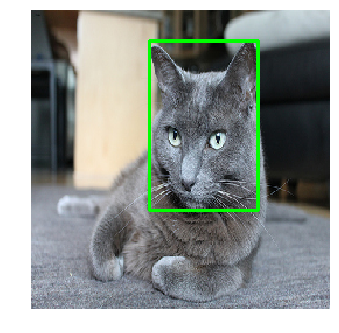

In [9]:
img = (x[0] * 255).astype('uint8')
box = y[0]
box = [int(IMG_SIZE *i) for i in box]

annotated = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.axis('off')
plt.imshow(annotated)

# Evaluation Metric

We use intersection over union metric (IoU) to evaluate the accuracy of the predicted bounding boxes. Visually, 

<center>![](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png =300x250)</center>


Mathematically, this is evaluated as 

$$IoU(b_{A}, b_{B}) = \frac{b_A \cap b_B}{b_A \cup b_B} $$




In [0]:
def iou(boxA, boxB):
  
  #evaluate the intersection points 
  xA = np.maximum(boxA[:, 0], boxB[:, 0])
  yA = np.maximum(boxA[:, 1], boxB[:, 1])

  xB = np.minimum(boxA[:, 2], boxB[:, 2])
  yB = np.minimum(boxA[:, 3], boxB[:, 3])

  # compute the area of intersection rectangle
  interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
  boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return tf.reduce_mean(np.mean(interArea / unionArea))

# Create the Model

In [0]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))
conv1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(inp)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

conv3 = Conv2D(63, (3, 3), padding = 'same', activation = 'relu')(pool2)
pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(pool3)
pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

conv5 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(pool4)
pool5 = MaxPooling2D(pool_size = (2, 2))(conv5)

conv6 = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(pool5)
pool6 = MaxPooling2D(pool_size = (2, 2))(conv6)

flatten = Flatten()(pool6)
dense1 = Dense(128, activation = 'relu')(flatten)
drop1  = Dropout(0.5)(dense1)
out = Dense(4, activation = 'sigmoid')(drop1)

model = tf.keras.models.Model(inputs = inp, outputs = out)
model.compile(optimizer = tf.train.AdamOptimizer() , loss = 'mean_squared_error', metrics = [iou])

#create a checkpoint for the best model 
model_save = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou', mode='max', save_weights_only= True, verbose = 0)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 63)        18207     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 63)        0         
__________

# Training

In [13]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps
                    ,callbacks=[model_save])

Epoch 1/30
109/109 [==============================] - 29s 265ms/step - loss: 0.0252 - iou: 0.7117 - val_loss: 0.0194 - val_iou: 0.7478
Epoch 2/30
109/109 [==============================] - 26s 242ms/step - loss: 0.0227 - iou: 0.7245 - val_loss: 0.0232 - val_iou: 0.7255
Epoch 3/30
109/109 [==============================] - 26s 236ms/step - loss: 0.0218 - iou: 0.7287 - val_loss: 0.0153 - val_iou: 0.7684
Epoch 4/30
109/109 [==============================] - 26s 236ms/step - loss: 0.0199 - iou: 0.7423 - val_loss: 0.0175 - val_iou: 0.7614
Epoch 5/30
109/109 [==============================] - 26s 236ms/step - loss: 0.0181 - iou: 0.7577 - val_loss: 0.0165 - val_iou: 0.7599
Epoch 6/30
109/109 [==============================] - 26s 237ms/step - loss: 0.0155 - iou: 0.7719 - val_loss: 0.0132 - val_iou: 0.7888
Epoch 7/30
109/109 [==============================] - 25s 233ms/step - loss: 0.0133 - iou: 0.7882 - val_loss: 0.0129 - val_iou: 0.7910
Epoch 8/30
109/109 [==============================] - 2

# Prediction 

In [0]:
#load the best model 
model.load_weights('best_model.h5')

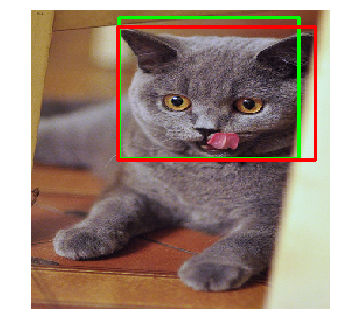

In [19]:
x,y = next(test_generator)
img = x[0]
box = model.predict(np.expand_dims(img, 0))[0]
box = [int(IMG_SIZE*i) for i in box]
annotated = cv2.rectangle((img*255) , (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
box = [int(IMG_SIZE * i) for i in y[0]]
annotated = cv2.rectangle((annotated) , (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.axis('off')
plt.imshow((annotated ).astype('uint8'))

# References



*   https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
*   https://github.com/lars76/object-localization

